# HW03: Distance and Topic Model

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

## Load and Pre-process Text

In [1]:
#Import the AG news dataset (same as hw01)
#Download them from here 
#!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


In [2]:
import spacy
dfs = df.sample(200, random_state=102)
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer

##TODO pre-process text as you did in HW02
dfs["processed"] = dfs["text"].apply(lambda x: nlp(x))
dfs['meaningful_toks'] = dfs['processed'].apply(lambda doc: [w.lemma_.lower() for w in doc if not w.is_stop and not w.is_punct and not w.is_digit])
dfs["input_TFIDF"] = dfs["meaningful_toks"].apply(lambda x: " ".join(x))

In [3]:
dfs.head()

,label,title,lead,text,processed,meaningful_toks,input_TFIDF
102378,business,GE Gives Airline Help On Leases,"ARLINGTON, Va. - US Airways Group said Friday ...","GE Gives Airline Help On Leases ARLINGTON, Va....","(GE, Gives, Airline, Help, On, Leases, ARLINGT...","[ge, give, airline, help, leases, arlington, v...",ge give airline help leases arlington va. airw...
50436,sport,Ravens #39; Battle Plans for Chiefs,"Once again, Ravens Insider staffer Dev Panchwa...",Ravens #39; Battle Plans for Chiefs Once again...,"(Ravens, #, 39, ;, Battle, Plans, for, Chiefs,...","[ravens, battle, plans, chiefs, ravens, inside...",ravens battle plans chiefs ravens insider staf...
61913,world,Rain in Boston Postpones BoSox-Yanks Game,BOSTON - Steady rain Friday night forced major...,Rain in Boston Postpones BoSox-Yanks Game BOST...,"(Rain, in, Boston, Postpones, BoSox, -, Yanks,...","[rain, boston, postpones, bosox, yanks, game, ...",rain boston postpones bosox yanks game boston ...
16282,world,Terrorists Storm School in Southern Russia,Armed terrorists stormed a school in southern ...,Terrorists Storm School in Southern Russia Arm...,"(Terrorists, Storm, School, in, Southern, Russ...","[terrorists, storm, school, southern, russia, ...",terrorists storm school southern russia armed ...
77900,business,Surge in car sales spurs economy,The final snapshot of the economy before Elect...,Surge in car sales spurs economy The final sna...,"(Surge, in, car, sales, spurs, economy, The, f...","[surge, car, sale, spur, economy, final, snaps...",surge car sale spur economy final snapshot eco...


In [67]:
##TODO vectorize the pre-processed text using TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.01, # When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
                        max_df=0.9,  # When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words).
                        max_features=1000,
                        stop_words='english',
                        use_idf=True, # the new piece
                        ngram_range=(1,1))

X_tfidf = tfidf.fit_transform(dfs['input_TFIDF'])

In [68]:
# Some exploration:
# The weights of each feature computed by the fit method call are stored in a model attribute:
# print(tfidf.idf_)
# tfidf.get_feature_names_out()
# This is the weighted counts of words in the first document:
# X_tfidf[0].toarray()
# tfidf matrix for first two documents and first 40 features
# X_tfidf.toarray()[:2, :40]

X_tfidf = X_tfidf.toarray()

## Cosine Similarity and PCA

cosine_similarity computes the L2-normalized dot product of vectors. This kernel is a popular choice for computing the similarity of documents represented as tf-idf vectors.

https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity

In [69]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

##TODO compute the cosine similarity for the first 200 snippets and for the first snippet, show the three most similar snippets and their respective cosine similarity scores

# Compute cosine similarity matrix
cos_sim_matrix = cosine_similarity(X_tfidf[:200])
#print(cos_sim_matrix[:1])

# Sort cosine similarity matrix for each document in descending order
cos_sim_sorted = np.argsort(-cos_sim_matrix)
#print(cos_sim_sorted[:1]) # the first element is always the snippet itself

# Select top three similar documents for each document
print(f"\nMost similar documents to: \n'{dfs.iloc[0]['text']}':\n")

for j in cos_sim_sorted[0][1:4]: # start with 1 to skip the first snippet itself
    print(f"Cosine similarity: '{round(cos_sim_matrix[0,j], 3)}' - Snippet: '{dfs.iloc[j]['text']}'")


Most similar documents to: 
'GE Gives Airline Help On Leases ARLINGTON, Va. - US Airways Group said Friday that it has reached agreement with General Electric Co. on aircraft leasing and financing terms to help the airline lower costs and reduce debt as it seeks to avoid liquidation.':

Cosine similarity: '0.171' - Snippet: 'Start-Up Offers Low-Power 'Personal Supercomputers'  NEW YORK (Reuters) - Lower electrical power consumption,  not just greater data processing oomph, will help a new class  of desktop supercomputers unveiled on Monday turn conventional  industry logic on its head, its designers say.'
Cosine similarity: '0.164' - Snippet: 'Delta Cutting Flights From OKC To Dallas-Fort Worth OKLAHOMA CITY -- Oklahoma will lose Delta Air Lines flights to the Dallas-Fort Worth International Airport as the airline restructures to try to avoid bankruptcy.'
Cosine similarity: '0.152' - Snippet: 'UPDATE 2-US Air seeks court-imposed cuts in wages, benefits Bankrupt US Airways Group Inc. (

In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')

##TODO reduce the vectorized data using PCA
Xpca = pca.fit_transform(X_tfidf)
pca.explained_variance_ratio_

array([0.01662543, 0.01416045, 0.01338677])

In [71]:
##TODO compute again cosine similarity with the reduced version for the first 200 snippets

# Compute cosine similarity matrix
cos_sim_matrix = cosine_similarity(Xpca[:200])

# Sort cosine similarity matrix for each document in descending order
cos_sim_sorted = np.argsort(-cos_sim_matrix)

##TODO for the first snippet, show again its three most similar snippets
# Select top three similar documents for each document
print(f"\nMost similar documents to: \n'{dfs.iloc[0]['text']}':\n")

for j in cos_sim_sorted[0][0:4]: # start with 1 to skip the first snippet itself
    print(f"Cosine similarity: '{round(cos_sim_matrix[0,j], 3)}' - Snippet: '{dfs.iloc[j]['text']}'")


Most similar documents to: 
'GE Gives Airline Help On Leases ARLINGTON, Va. - US Airways Group said Friday that it has reached agreement with General Electric Co. on aircraft leasing and financing terms to help the airline lower costs and reduce debt as it seeks to avoid liquidation.':

Cosine similarity: '1.0' - Snippet: 'GE Gives Airline Help On Leases ARLINGTON, Va. - US Airways Group said Friday that it has reached agreement with General Electric Co. on aircraft leasing and financing terms to help the airline lower costs and reduce debt as it seeks to avoid liquidation.'
Cosine similarity: '0.988' - Snippet: 'Royal Group Removes Chairman De Zen, Dunsmuir, Goegan (Update3) Royal Group Technologies Ltd. fired Chairman Vic De Zen and Chief Executive Douglas Dunsmuir, targets of a police probe, after finding they failed to disclose their interest in a parcel of land sold to the company in 1998.'
Cosine similarity: '0.937' - Snippet: 'NFL : McNabb, Owens torch Cowboys While it was sure

In [53]:
# From solutions, gives the same result:

##TODO compute again cosine similarity with the reduced version for the first 200 snippets
sim_pca = cosine_similarity(Xpca[:200])
##TODO for the first snippet, show again its three most similar snippets
sim_to_text1 = sim_pca[0, :]

doc_n_sim = zip(range(len(sim_to_text1)), sim_to_text1)
doc_n_sim = sorted(doc_n_sim, key=lambda x: x[1], reverse=True)

print('The first snippet:')
print(dfs.iloc[doc_n_sim[0][0]]['text'])
print(' ')
print('Three most similar snippets:')
print(doc_n_sim[1][1])
print(dfs.iloc[doc_n_sim[1][0]]['text'])
print(' ')
print(doc_n_sim[2][1])
print(dfs.iloc[doc_n_sim[2][0]]['text'])
print(' ')
print(doc_n_sim[3][1])
print(dfs.iloc[doc_n_sim[3][0]]['text'])

The first snippet:
GE Gives Airline Help On Leases ARLINGTON, Va. - US Airways Group said Friday that it has reached agreement with General Electric Co. on aircraft leasing and financing terms to help the airline lower costs and reduce debt as it seeks to avoid liquidation.
 
Three most similar snippets:
0.9843793901157172
Karzai leads race in Afghan presidential polls: World News: Kabul, Oct 18 : Incumbent Afghan President Hamid Karzai is maintaining his edge over rivals, having secured 62 percent of the votes counted so far, reports Xinhua.
 
0.9809790444479694
Serena the 'Entertainer' Wins at U.S. Open (AP) AP - This is all you need to know about Serena Williams' concerns at the U.S. Open: After warming up for what would be a 6-4, 6-3 second-round victory Wednesday against Lindsay Lee-Waters, Williams approached the chair umpire with an urgent request  #151; could someone get her purse from the locker room? She forgot to put on earrings.
 
0.9688629791706015
U.N. to Deliver Aid to H

Compare the cosine similarity before and after PCA reduction. Did the results change? 

Yes, the cosine similarities are much higher now and the most similar snippets also changes.

## Clustering

In [62]:
# Instead of tfidf, try with count vectorizer -> they did not do this in the solutions
#from sklearn.feature_extraction.text import CountVectorizer
#vec = CountVectorizer(min_df=0.01, # at min 1% of docs
#                        max_features=1000,
#                        stop_words='english',
#                        max_df=.9,  
#                        ngram_range=(1,3))
#X_tfidf = vec.fit_transform(dfs['input_TFIDF'])

In [72]:
# !pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

##TODO create the clusters found with k-medoids clustering and 5 clusters
kmed = KMedoids(n_clusters=5)
kmed.fit(X_tfidf)
doc_clusters = kmed.labels_.tolist()
dfs['cluster_medoid'] = doc_clusters

In [73]:
##TODO create the clusters found with k-means clustering and 5 clusters
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5, n_init=10)
km.fit(X_tfidf)
doc_clusters = km.labels_.tolist()
dfs['cluster_means'] = doc_clusters

(200, 730)
(200, 2)


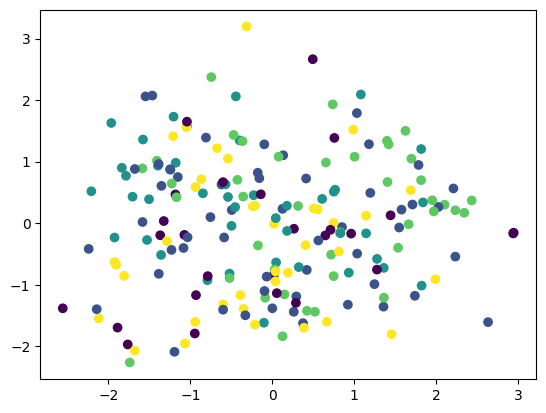

In [74]:
##TODO visualize the k-medoids clustering results through Isomap (first reduce the dimensionality to 2 using Isomap, then use scatter plot (plt.scatter()) to visualize)

# Reduce dimensionality to 2
from sklearn.manifold import Isomap
print(X_tfidf.shape)
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(X_tfidf)
print(X_transformed.shape)

# Plot the data in the reduced two-dimensional space
import matplotlib.pyplot as plt
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=dfs['cluster_medoid'])
plt.show()

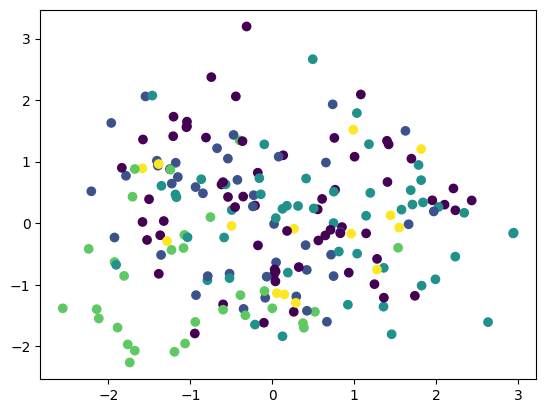

In [75]:
##TODO similarly, visualize the k-means results

plt.scatter(X_transformed[:,0], X_transformed[:,1], c=dfs['cluster_means'])
plt.show()

## Topic Modeling: LDA

For this part you will need to use LDA Mallet. If you cannot have Mallet run, you can use the simple LDA algorithm 

In [76]:
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel

##TODO create a dictionary with the pre-processed tokenized text and filter it according to frequencies and keeping 1000 vocabularies

## clean document
##from gensim.utils import simple_preprocess
#from spacy.tokenizer import Tokenizer
#from tqdm import tqdm as tq
#
#def tokenize(x, nlp):
#    # lemmatize and lowercase without stopwords, punctuation and numbers
#    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct and not w.is_digit and len(w) > 2]
#
## split into paragraphs
#doc_clean = []
#for doc in tq(dfs['text']):
#    # split by paragraph
#    for paragraph in doc.split("\n\n"):
#        doc_clean.append(tokenize(paragraph, nlp))
#print(doc_clean[:2])
#
## randomize document order
#from random import shuffle
#shuffle(doc_clean)

# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(dfs['meaningful_toks'])
# filter extremes, drop all words appearing in less than 10 paragraphs and all words appearing in at least every third paragraph
#dictionary.filter_extremes(keep_n=1000)
print(len(dictionary))

2400


In [77]:
##TODO create the doc_term_matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in dfs['meaningful_toks']]

In [78]:
##TODO train a LDA Mallet model with 5, 10 and 15 topics

# LDA Mallet did not work, use simple LDA instead
# train LDA with 10 topics and print 
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=5, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=True)

[(0,
  '0.010*"=" + 0.010*" " + 0.008*"say" + 0.006*"win" + 0.004*"year" + 0.004*"chief" + 0.004*"39;s" + 0.003*"state" + 0.003*"wednesday" + 0.003*"airlines"'),
 (1,
  '0.014*"39;s" + 0.006*"say" + 0.005*"price" + 0.004*"high" + 0.004*"rise" + 0.004*"report" + 0.004*"beijing" + 0.004*"fall" + 0.004*"korean" + 0.003*"ap"'),
 (2,
  '0.007*"year" + 0.005*"friday" + 0.005*"new" + 0.005*"39;s" + 0.004*"high" + 0.004*"school" + 0.004*"people" + 0.003*"microsoft" + 0.003*"say" + 0.003*"file"'),
 (3,
  '0.024*" " + 0.008*"new" + 0.006*"year" + 0.006*"ap" + 0.006*"say" + 0.005*"39;s" + 0.004*"reuters" + 0.004*"stock" + 0.004*"release" + 0.004*"set"'),
 (4,
  '0.009*"say" + 0.009*"ap" + 0.007*"39;s" + 0.006*"company" + 0.005*" " + 0.004*"bush" + 0.004*"president" + 0.004*"vote" + 0.004*"oil" + 0.004*"peoplesoft"')]

In [286]:
lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=True)

[(0,
  '0.082*"year" + 0.052*"new" + 0.029*"game" + 0.028*"friday" + 0.025*"good" + 0.025*"fall" + 0.024*"want" + 0.019*"technology" + 0.018*"39;s" + 0.016*"report"'),
 (1,
  '0.046*"say" + 0.037*"win" + 0.035*"vote" + 0.033*"bank" + 0.030*"year" + 0.029*"u.s." + 0.028*"demand" + 0.028*"39;s" + 0.027*"early" + 0.023*"north"'),
 (2,
  '0.074*"price" + 0.072*"gold" + 0.054*"high" + 0.049*"say" + 0.032*"39;s" + 0.029*"work" + 0.028*"post" + 0.028*"report" + 0.028*"earning" + 0.020*"giant"'),
 (3,
  '0.068*"say" + 0.042*"take" + 0.038*"state" + 0.034*"school" + 0.033*"year" + 0.030*"wednesday" + 0.029*"thursday" + 0.022*"work" + 0.022*"corp." + 0.022*"people"'),
 (4,
  '0.050*"39;s" + 0.045*"year" + 0.045*"start" + 0.041*"open" + 0.041*"chief" + 0.028*"say" + 0.028*"find" + 0.028*"stock" + 0.028*"run" + 0.028*"profit"'),
 (5,
  '0.051*"release" + 0.038*"39;s" + 0.033*"president" + 0.028*"user" + 0.022*"world" + 0.022*"night" + 0.022*"final" + 0.022*"city" + 0.022*"get" + 0.022*"stock"'),
 

In [287]:
##TODO compute the coherence score for each of these model and print the topics from the model with 
# highest coherence score. Then find the opitimal number of topics using the coherence score.

In [79]:
#!pip install pyLDAvis
import pyLDAvis.gensim
from gensim.models import wrappers

##TODO using LDAvis visualize the topics using the optimal number of topics

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)

c:\Users\kschuepbach\.conda\envs\nlp_lss\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.047944  0.121729       1        1  26.505369
0     -0.133841  0.015673       2        1  20.119992
2      0.036260 -0.068888       3        1  19.543577
4      0.007009 -0.047165       4        1  17.031097
1      0.042628 -0.021348       5        1  16.799965, topic_info=               Term       Freq      Total Category  logprob  loglift
162                  53.000000  53.000000  Default  30.0000  30.0000
1149              =  14.000000  14.000000  Default  29.0000  29.0000
242            39;s  34.000000  34.000000  Default  28.0000  28.0000
261            rise   6.000000   6.000000  Default  27.0000  27.0000
1076        beijing   3.000000   3.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
162                   2.701471  53.376279   Topic5  -5.7769  -1.1998
234   international   2.073969   7.441100   Topic5  -6.0412   0.5062
88        wednesday   2.145287  12.328251   Topic5  -6.0074   0.0352
267         company   2.096702  12.902113   Topic5  -6.0303  -0.0332
101            sale   2.043562   6.578358   Topic5  -6.0560   0.6147

[329 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
162       1  0.618252      
162       2  0.187349      
162       3  0.037470      
162       4  0.093675      
162       5  0.056205      
...     ...       ...   ...
66        1  0.629001  york
66        2  0.157250  york
66        3  0.157250  york
66        4  0.157250  york
1339      5  0.770287   zoo

[508 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 5, 2])